## Compute Surface Laplacian on Epoched data.

Script to define a function that computes the surface laplacian given an MNE Epochs object.
The Epochs object is surface laplacian transformed.
The topographies of the original data and the surface laplacian transformed data are compared.
This uses the data that was prepared using the script, *DataSC_PrepareEpoched.py* or *DataSC_PrepareEpoched.ipynb*


In [2]:

import numpy as np
from scipy import special
import math
import mne
import pylab as plt

# LOAD IN THE EPOCHED DATA
"""
    LOAD IN THE EPOCHED DATA
"""
fname = 'audoddball_std-epo.fif'
epochIn = mne.read_epochs(fname, preload=False)

# Get the electrode montage.
montageIn = epochIn.get_montage()


Reading /Users/bolger/PycharmProjects/MASCO_DataSC_2023/audoddball_std-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


#### Compute the Surface Laplacian

The following function computes the surface laplacian on an MNE Epochs object.
The following variables are passed to the function:
    - epochs: the Epochs object
    - leg_order: the max. order of the Legendre polynomial
    - m: the smoothness parameter
    - montage: the montage applied to the Epochs object.

The following variables are returned by this function:
    - pre_laplace: data before applying Laplacian
    - post_place:  surface laplacian transform of the Epochs object.

In [3]:
## Function to compute surface laplacian on segmented data.
def surface_laplacian(epochs, leg_order, m, smoothing):
    """
    This function attempts to compute the surface laplacian transform to an mne Epochs object. The
    algorithm follows the formulations of Perrin et al. (1989).

    INPUTS are:
        - epochs: mne Epochs object
        - leg_order: maximum order of the Legendre polynomial
        - m: smothness parameter for G and H
        - smoothing: smothness parameter for the diagonal of G
        - montage: montage to reconstruct the transformed Epochs object (same as in raw data import)

    OUTPUTS are:
        - pre_laplace: unaffected reconstruction of the original Epochs object
        - post_laplace: surface laplacian transform of the original Epochs object

    References:
        - Perrin, F., Pernier, J., Bertrand, O. & Echallier, J.F. (1989). Spherical splines for scalp
          potential and current density mapping. Electroencephalography and clinical Neurophysiology, 72,
          184-187.

    """
    # import libraries
    import numpy as np
    from scipy import special
    import math
    import mne
    import matplotlib.pyplot as plt


    # get electrodes positions
    locs = epochs._get_channel_positions()

    x = locs[:, 0]
    y = locs[:, 1]
    z = locs[:, 2]

    # arrange data
    data = epochs.get_data()  # data
    data = np.rollaxis(data, 0, 3)
    orig_data_size = np.squeeze(data.shape)

    numelectrodes = len(x)

    # normalize cartesian coordenates to sphere unit
    def cart2sph(x, y, z):
        hxy = np.hypot(x, y)
        r = np.hypot(hxy, z)
        el = np.arctan2(z, hxy)
        az = np.arctan2(y, x)
        return az, el, r

    junk1, junk2, spherical_radii = cart2sph(x, y, z)
    maxrad = np.max(spherical_radii)
    x = x / maxrad
    y = y / maxrad
    z = z / maxrad

    # compute cousine distance between all pairs of electrodes
    cosdist = np.zeros((numelectrodes, numelectrodes))
    for i in range(numelectrodes):
        for j in range(i + 1, numelectrodes):
            cosdist[i, j] = 1 - (((x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2 + (z[i] - z[j]) ** 2) / 2)

    cosdist = cosdist + cosdist.T + np.identity(numelectrodes)

    # get legendre polynomials
    legpoly = np.zeros((leg_order, numelectrodes, numelectrodes))
    for ni in range(leg_order):
        for i in range(numelectrodes):
            for j in range(i + 1, numelectrodes):
                # temp = special.lpn(8,cosdist[0,1])[0][8]
                legpoly[ni, i, j] = special.lpn(ni + 1, cosdist[i, j])[0][ni + 1]

    legpoly = legpoly + np.transpose(legpoly, (0, 2, 1))

    for i in range(leg_order):
        legpoly[i, :, :] = legpoly[i, :, :] + np.identity(numelectrodes)

    # compute G and H matrixes
    twoN1 = np.multiply(2, range(1, leg_order + 1)) + 1
    gdenom = np.power(np.multiply(range(1, leg_order + 1), range(2, leg_order + 2)), m, dtype=float)
    hdenom = np.power(np.multiply(range(1, leg_order + 1), range(2, leg_order + 2)), m - 1, dtype=float)

    G = np.zeros((numelectrodes, numelectrodes))
    H = np.zeros((numelectrodes, numelectrodes))

    for i in range(numelectrodes):
        for j in range(i, numelectrodes):

            g = 0
            h = 0

            for ni in range(leg_order):
                g = g + (twoN1[ni] * legpoly[ni, i, j]) / gdenom[ni]
                h = h - (twoN1[ni] * legpoly[ni, i, j]) / hdenom[ni]

            G[i, j] = g / (4 * math.pi)
            H[i, j] = -h / (4 * math.pi)

    G = G + G.T
    H = H + H.T

    G = G - np.identity(numelectrodes) * G[1, 1] / 2
    H = H - np.identity(numelectrodes) * H[1, 1] / 2

    # Plot the G and H matrix
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    imG = plt.imshow(G, cmap="copper_r")
    plt.colorbar(imG)
    ax.set_title('G matrix')
    ax = fig.add_subplot(1, 2, 2)
    imH = plt.imshow(H, cmap="copper_r")
    plt.colorbar(imH)
    ax.set_title('H matrix')

    if np.any(orig_data_size == 1):
        data = data[:]
    else:
        data = np.reshape(data, (orig_data_size[0], np.prod(orig_data_size[1:3])))

    # compute C matrix
    Gs = G + np.identity(numelectrodes) * smoothing
    GsinvS = np.sum(np.linalg.inv(Gs), 0)
    dataGs = np.dot(data.T, np.linalg.inv(Gs))
    C = dataGs - np.dot(np.atleast_2d(np.sum(dataGs, 1) / np.sum(GsinvS)).T, np.atleast_2d(GsinvS))

    # apply transform
    original = np.reshape(data, orig_data_size)
    surf_lap = np.reshape(np.transpose(np.dot(C, np.transpose(H))), orig_data_size)

    # re-arrange data into mne's Epochs object
    events = epochs.events
    event_id = epochs.event_id
    ch_names = epochs.ch_names
    sfreq = epochs.info['sfreq']
    tmin = epochs.tmin
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')

    original = np.rollaxis(original, 2, 0)
    surf_lap = np.rollaxis(surf_lap, 2, 0)

    pre_laplace = mne.EpochsArray(data=original, info=info, events=events, event_id=event_id, tmin=tmin, on_missing='ignore')
    post_laplace = mne.EpochsArray(data=surf_lap, info=info, events=events, event_id=event_id, tmin=tmin, on_missing='ignore')

    return pre_laplace, post_laplace


### CALL OF SURFACE LAPLACIAN FUNCTION

Call the surface_laplacian() function to get the surface laplacian transformed Epochs object.

- Plot the ERPs of the original and laplacian transformed Epochs objects to compare. You can plot individual channels to explore in detail.
- Plot the spatial distribution of the original and the laplacian transformed data.

Loading data for 60 events and 551 original time points ...
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated


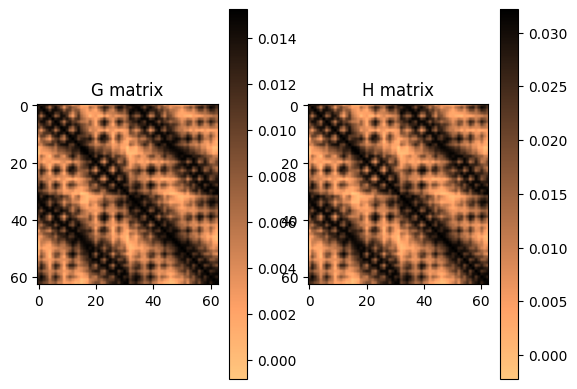

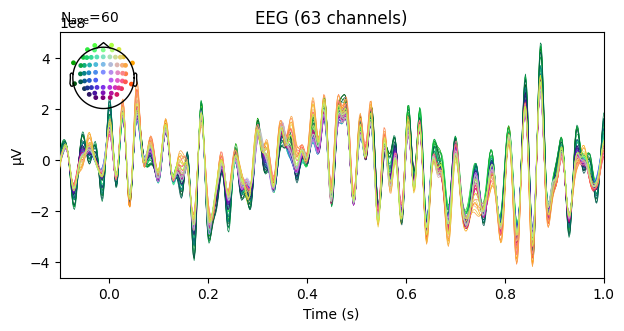

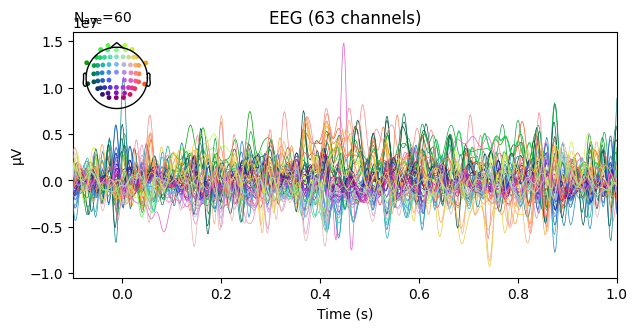

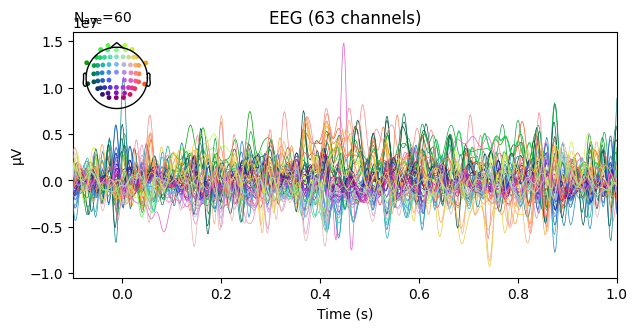

In [5]:
### CALL OF SURFACE LAPLACIAN FUNCTION
surf_lap, surf_orig = surface_laplacian(epochs=epochIn, m=4, leg_order=50, smoothing=1e-5)

# Add electrode montage
surf_lap.set_montage(montageIn)
surf_orig.set_montage(montageIn)

# make ERPs
bf_erp = surf_orig.average()
at_erp = surf_lap.average()

# Plot the ERP data
bf_erp.plot()
at_erp.plot()

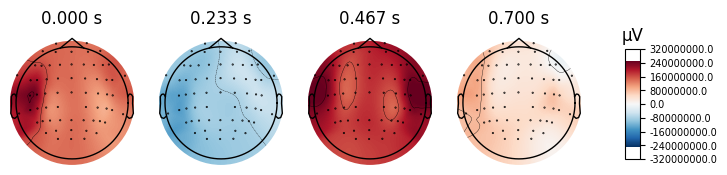

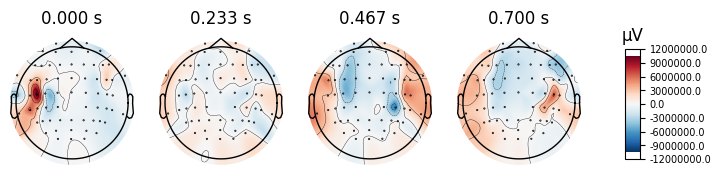

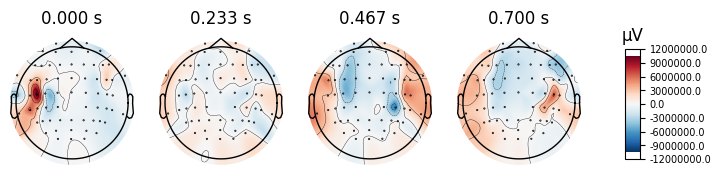

In [7]:
# plot topographies over the entire epoch duration or for a certain time window of interest.
# NOTE: np.arange(start, end, step)

times = np.linspace(0.0, 0.7, 4)
bf_erp.plot_topomap(ch_type='eeg', times=times, colorbar=True)
at_erp.plot_topomap(ch_type='eeg', times=times, colorbar=True)

#bf_erp.plot_topomap(np.arange(0, 0.7, 0.1), vmin=-200, vmax=200, units="$\mu V$", time_unit='ms', cmap="jet", title="Voltage", scalings=dict(eeg=1e5))
#at_erp.plot_topomap(np.arange(0, 0.7, 0.1), vmin=-120, vmax=120, units="$\mu V/mm^2$", time_unit='ms', cmap="jet", title="Laplacian", scalings=dict(eeg=2e6))